# Out-of-sample forecasting experiments

I conduct out-of-sample forecasting experiments to understand what kind of text data (topics, sentiment, or uncertainty) helps improve forecasts of three quarterly variables (GDP, Investment, and Consumption) more.

In this notebook, I evaluate the performance of dynamic factor models (DFM) using hard data, survey information, and 10 sign-adjusted topics (BCC) (out of 200 topics estimated on articles published before 2010 using all sources) most correlated with Investment growth. I forecast Investment growth and integrate text data into economic forecasting.

## Experiment Details

- **Data Sources:** Hard data, surveys, 10 pre-selected sign-adjusted topics, BCC (<=2009, 200 topics, all sources).
- **Forecast Target:** Investment growth.
- **Model:** Dynamic Factor Models (DFM).
- **Parameters Explored:**
  - **Number of Hard+Surveys Factors:** 1 to 2
  - **Number of Text Factors:** 1
  - **Factor Order:** 1 to 3

In [1]:
import os
import time
import datetime
import pandas as pd
import DFM_function_update

# Define inputs common to all models
q_var = 'Investment'                      # quarterly variable being forecasted
additional_factors = 'HardSurveys+Text'   # switch to separate factors scenario
start = '1991-04'
text_type = "topics_BCC"
estimation_period = "2009"
num_topics = "200"
source = "all"
selected = ""
with_text = True

# Generate list of forecast_month strings for quarters from 2008Q1 to 2018Q4
# forecast_month is set to the month corresponding to quarter-end:
# Q1: 'YYYY-03', Q2: 'YYYY-06', Q3: 'YYYY-09', Q4: 'YYYY-12'
forecast_months = []
for year in range(2008, 2019):
    forecast_months.extend([f"{year}-03", f"{year}-06", f"{year}-09", f"{year}-12"])
    
# Define the vintage column names 
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Create directories to save forecasts and MSE results
os.makedirs(f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_{q_var}_update", exist_ok=True)
os.makedirs(f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_{q_var}_update", exist_ok=True)

# Load the actual growth data
actual_growth_file = f"../{q_var}_growth_actual_update.csv"
actual_growth = pd.read_csv(actual_growth_file)

# Record overall start time
overall_start = time.time()

# Loop over the number of HardSurveys factors (1 or 2) and factor order values from 1 to 3
for num_factors in range(1, 3):  # 1 or 2 HardSurveys factors
    for order in range(1, 4):    # Varying factor order: 1, 2, 3
        
        # Define model-specific parameters
        factor_multiplicities = {'HardSurveys': num_factors, 'Text': 1}
        factor_orders = {'HardSurveys': order, 'Text': order}

        # Prepare lists to store each quarter's forecasts and row labels
        forecasts_all_quarters = []
        row_labels = []
        
        # Start timing for this model
        start_time = time.time()

        # Loop over each forecast month, get the forecasts, and store the results
        for fm in forecast_months:
            # Use the forecast_month string as the row label
            row_labels.append(fm)

            # Run the forecast function for this quarter
            forecasts_dict = DFM_function_update.get_forecasts(
                forecast_month = fm,
                q_var = q_var,
                additional_factors = additional_factors,
                factor_multiplicities = factor_multiplicities,
                factor_orders = factor_orders,
                start = start,
                text_type = text_type,
                estimation_period = estimation_period,
                num_topics = num_topics,
                source = source,
                selected = selected,
                with_text = with_text
            )

            # Obtain the correct ordering of vintages
            vintages_order = DFM_function_update.vintage_dates(fm)
            # Extract the forecast value for each vintage in that order
            quarter_forecasts = [forecasts_dict[vint] for vint in vintages_order]
            forecasts_all_quarters.append(quarter_forecasts)

        # Create a DataFrame with rows labeled by the forecast_month strings and columns as vintage names
        results = pd.DataFrame(forecasts_all_quarters, index=row_labels, columns=vintage_col_names)
        
        # Stop timing for this model and print elapsed time
        elapsed = time.time() - start_time
        elapsed_time = datetime.timedelta(seconds=elapsed)
        print(f"Model with HardSurveys factors = {num_factors} and order = {order} estimated in {elapsed_time}.")
        
        # Construct the output file name
        factors_str = f"HS_{num_factors}_{order}"
        file_name = f"forecasts_{q_var}_{factors_str}.csv"

        # Save the CSV file in a subfolder 
        output_path = os.path.join(f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_{q_var}_update", file_name)
        results.to_csv(output_path, index=True)
        
        # ----- MSE Calculation -----
        # Load forecasts
        forecasts = pd.read_csv(output_path, index_col=0)
        # Make sure the index is a column named "date"
        forecasts.index.name = "date"
        forecasts.reset_index(inplace=True)

        # Merge dfs by date 
        merged = pd.merge(forecasts, actual_growth, on="date", how="inner")

        # Calculate the Mean Squared Error (MSE) for each vintage column
        mse_dict = {}
        for col in vintage_col_names:
            mse = ((merged[col] - merged["growth"]) ** 2).mean()
            mse_dict[col] = mse

        # Create a df with one row (the MSE values for each forecasting horizon)
        mse_df = pd.DataFrame(mse_dict, index=[0])

        # Save MSE results to CSV
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_output_path = os.path.join(f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_{q_var}_update", mse_file_name)
        mse_df.to_csv(mse_output_path, index=False)
        
# Stop overall timing and print overall elapsed time
overall_elapsed = time.time() - overall_start
overall_elapsed_time = datetime.timedelta(seconds=overall_elapsed)
print(f"Overall time taken for running all models: {overall_elapsed_time}.")

EM start iterations, llf=-11652
EM converged at iteration 38, llf=-11413, convergence criterion=9.9341e-07 < tolerance=1e-06
EM start iterations, llf=-11665
EM converged at iteration 39, llf=-11425, convergence criterion=9.5736e-07 < tolerance=1e-06
EM start iterations, llf=-11713
EM converged at iteration 39, llf=-11472, convergence criterion=9.889e-07 < tolerance=1e-06
EM start iterations, llf=-11719
EM converged at iteration 39, llf=-11479, convergence criterion=9.8757e-07 < tolerance=1e-06
EM start iterations, llf=-11791
EM converged at iteration 38, llf=-11545, convergence criterion=9.882e-07 < tolerance=1e-06
EM start iterations, llf=-11800
EM converged at iteration 38, llf=-11552, convergence criterion=9.6975e-07 < tolerance=1e-06
EM start iterations, llf=-11857
EM converged at iteration 38, llf=-11610, convergence criterion=9.7726e-07 < tolerance=1e-06
EM start iterations, llf=-11857
EM converged at iteration 38, llf=-11610, convergence criterion=9.7726e-07 < tolerance=1e-06
EM

EM start iterations, llf=-13129
EM converged at iteration 34, llf=-12943, convergence criterion=9.5651e-07 < tolerance=1e-06
EM start iterations, llf=-13194
EM converged at iteration 31, llf=-13018, convergence criterion=9.3642e-07 < tolerance=1e-06
EM start iterations, llf=-13200
EM converged at iteration 33, llf=-13021, convergence criterion=9.7673e-07 < tolerance=1e-06
EM start iterations, llf=-13252
EM converged at iteration 34, llf=-13069, convergence criterion=9.8316e-07 < tolerance=1e-06
EM start iterations, llf=-13252
EM converged at iteration 34, llf=-13069, convergence criterion=9.8316e-07 < tolerance=1e-06
EM start iterations, llf=-13264
EM converged at iteration 35, llf=-13082, convergence criterion=9.8005e-07 < tolerance=1e-06
EM start iterations, llf=-13316
EM converged at iteration 35, llf=-13134, convergence criterion=9.3854e-07 < tolerance=1e-06
EM start iterations, llf=-13321
EM converged at iteration 35, llf=-13138, convergence criterion=9.9306e-07 < tolerance=1e-06


EM start iterations, llf=-14793
EM converged at iteration 35, llf=-14594, convergence criterion=9.5009e-07 < tolerance=1e-06
EM start iterations, llf=-14793
EM converged at iteration 35, llf=-14594, convergence criterion=9.5009e-07 < tolerance=1e-06
EM start iterations, llf=-14802
EM converged at iteration 35, llf=-14603, convergence criterion=9.4905e-07 < tolerance=1e-06
EM start iterations, llf=-14853
EM converged at iteration 35, llf=-14654, convergence criterion=9.3444e-07 < tolerance=1e-06
EM start iterations, llf=-14864
EM converged at iteration 35, llf=-14665, convergence criterion=9.2677e-07 < tolerance=1e-06
EM start iterations, llf=-14912
EM converged at iteration 34, llf=-14712, convergence criterion=9.8186e-07 < tolerance=1e-06
EM start iterations, llf=-14919
EM converged at iteration 34, llf=-14719, convergence criterion=9.6494e-07 < tolerance=1e-06
EM start iterations, llf=-14963
EM converged at iteration 34, llf=-14762, convergence criterion=9.5013e-07 < tolerance=1e-06


EM start iterations, llf=-16517
EM converged at iteration 31, llf=-16287, convergence criterion=9.1072e-07 < tolerance=1e-06
EM start iterations, llf=-16522
EM converged at iteration 31, llf=-16292, convergence criterion=9.1161e-07 < tolerance=1e-06
EM start iterations, llf=-16573
EM converged at iteration 31, llf=-16343, convergence criterion=8.9137e-07 < tolerance=1e-06
EM start iterations, llf=-16580
EM converged at iteration 31, llf=-16349, convergence criterion=8.9959e-07 < tolerance=1e-06
EM start iterations, llf=-16636
EM converged at iteration 31, llf=-16405, convergence criterion=8.9223e-07 < tolerance=1e-06
EM start iterations, llf=-16636
EM converged at iteration 31, llf=-16405, convergence criterion=8.9223e-07 < tolerance=1e-06
EM start iterations, llf=-16645
EM converged at iteration 30, llf=-16415, convergence criterion=9.8467e-07 < tolerance=1e-06
EM start iterations, llf=-16696
EM converged at iteration 30, llf=-16466, convergence criterion=9.4124e-07 < tolerance=1e-06


EM start iterations, llf=-18039
EM converged at iteration 26, llf=-17791, convergence criterion=8.8092e-07 < tolerance=1e-06
EM start iterations, llf=-18095
EM converged at iteration 26, llf=-17846, convergence criterion=8.812e-07 < tolerance=1e-06
EM start iterations, llf=-18095
EM converged at iteration 26, llf=-17846, convergence criterion=8.812e-07 < tolerance=1e-06
EM start iterations, llf=-18101
EM converged at iteration 26, llf=-17851, convergence criterion=8.8182e-07 < tolerance=1e-06
EM start iterations, llf=-18152
EM converged at iteration 26, llf=-17901, convergence criterion=9.1138e-07 < tolerance=1e-06
EM start iterations, llf=-18159
EM converged at iteration 26, llf=-17908, convergence criterion=9.1159e-07 < tolerance=1e-06
EM start iterations, llf=-18215
EM converged at iteration 26, llf=-17963, convergence criterion=9.1615e-07 < tolerance=1e-06
EM start iterations, llf=-18223
EM converged at iteration 26, llf=-17971, convergence criterion=9.2144e-07 < tolerance=1e-06
EM

EM start iterations, llf=-12212
EM converged at iteration 45, llf=-11949, convergence criterion=9.6945e-07 < tolerance=1e-06
EM start iterations, llf=-12194
EM converged at iteration 44, llf=-11928, convergence criterion=9.6876e-07 < tolerance=1e-06
EM start iterations, llf=-12227
EM converged at iteration 44, llf=-11965, convergence criterion=9.7407e-07 < tolerance=1e-06
EM start iterations, llf=-12245
EM converged at iteration 44, llf=-11990, convergence criterion=9.8262e-07 < tolerance=1e-06
EM start iterations, llf=-12270
EM converged at iteration 48, llf=-12038, convergence criterion=9.7055e-07 < tolerance=1e-06
EM start iterations, llf=-12269
EM converged at iteration 47, llf=-12035, convergence criterion=9.9393e-07 < tolerance=1e-06
EM start iterations, llf=-12269
EM converged at iteration 45, llf=-12045, convergence criterion=9.5689e-07 < tolerance=1e-06
EM start iterations, llf=-12269
EM converged at iteration 45, llf=-12045, convergence criterion=9.5689e-07 < tolerance=1e-06


EM start iterations, llf=-13626
EM converged at iteration 53, llf=-13433, convergence criterion=9.7039e-07 < tolerance=1e-06
EM start iterations, llf=-13647
EM converged at iteration 51, llf=-13448, convergence criterion=9.9621e-07 < tolerance=1e-06
EM start iterations, llf=-13653
EM converged at iteration 53, llf=-13460, convergence criterion=9.8423e-07 < tolerance=1e-06
EM start iterations, llf=-13701
EM converged at iteration 56, llf=-13516, convergence criterion=9.936e-07 < tolerance=1e-06
EM start iterations, llf=-13701
EM converged at iteration 56, llf=-13516, convergence criterion=9.936e-07 < tolerance=1e-06
EM start iterations, llf=-13712
EM converged at iteration 56, llf=-13527, convergence criterion=9.962e-07 < tolerance=1e-06
EM start iterations, llf=-13763
EM converged at iteration 56, llf=-13577, convergence criterion=9.7617e-07 < tolerance=1e-06
EM start iterations, llf=-13771
EM converged at iteration 55, llf=-13583, convergence criterion=9.805e-07 < tolerance=1e-06
EM s

EM start iterations, llf=-15346
EM converged at iteration 47, llf=-15133, convergence criterion=9.8279e-07 < tolerance=1e-06
EM start iterations, llf=-15346
EM converged at iteration 47, llf=-15133, convergence criterion=9.8279e-07 < tolerance=1e-06
EM start iterations, llf=-15354
EM converged at iteration 46, llf=-15141, convergence criterion=9.9774e-07 < tolerance=1e-06
EM start iterations, llf=-15411
EM converged at iteration 46, llf=-15197, convergence criterion=9.9942e-07 < tolerance=1e-06
EM start iterations, llf=-15414
EM converged at iteration 47, llf=-15198, convergence criterion=9.7094e-07 < tolerance=1e-06
EM start iterations, llf=-15475
EM converged at iteration 47, llf=-15258, convergence criterion=9.6532e-07 < tolerance=1e-06
EM start iterations, llf=-15479
EM converged at iteration 46, llf=-15262, convergence criterion=9.9957e-07 < tolerance=1e-06
EM start iterations, llf=-15521
EM converged at iteration 47, llf=-15305, convergence criterion=9.6559e-07 < tolerance=1e-06


EM start iterations, llf=-17080
EM converged at iteration 38, llf=-16853, convergence criterion=9.5859e-07 < tolerance=1e-06
EM start iterations, llf=-17086
EM converged at iteration 38, llf=-16859, convergence criterion=9.5806e-07 < tolerance=1e-06
EM start iterations, llf=-17140
EM converged at iteration 37, llf=-16911, convergence criterion=9.9549e-07 < tolerance=1e-06
EM start iterations, llf=-17148
EM converged at iteration 37, llf=-16918, convergence criterion=9.9496e-07 < tolerance=1e-06
EM start iterations, llf=-17196
EM converged at iteration 37, llf=-16965, convergence criterion=9.8882e-07 < tolerance=1e-06
EM start iterations, llf=-17196
EM converged at iteration 37, llf=-16965, convergence criterion=9.8882e-07 < tolerance=1e-06
EM start iterations, llf=-17215
EM converged at iteration 37, llf=-16985, convergence criterion=9.9557e-07 < tolerance=1e-06
EM start iterations, llf=-17268
EM converged at iteration 36, llf=-17038, convergence criterion=9.917e-07 < tolerance=1e-06
E

EM start iterations, llf=-18572
EM converged at iteration 36, llf=-18312, convergence criterion=9.9924e-07 < tolerance=1e-06
EM start iterations, llf=-18621
EM converged at iteration 36, llf=-18362, convergence criterion=9.7356e-07 < tolerance=1e-06
EM start iterations, llf=-18621
EM converged at iteration 36, llf=-18362, convergence criterion=9.7356e-07 < tolerance=1e-06
EM start iterations, llf=-18629
EM converged at iteration 36, llf=-18371, convergence criterion=9.7113e-07 < tolerance=1e-06
EM start iterations, llf=-18684
EM converged at iteration 36, llf=-18426, convergence criterion=9.692e-07 < tolerance=1e-06
EM start iterations, llf=-18692
EM converged at iteration 36, llf=-18433, convergence criterion=9.6799e-07 < tolerance=1e-06
EM start iterations, llf=-18743
EM converged at iteration 36, llf=-18484, convergence criterion=9.6506e-07 < tolerance=1e-06
EM start iterations, llf=-18752
EM converged at iteration 36, llf=-18492, convergence criterion=9.6387e-07 < tolerance=1e-06
E

EM converged at iteration 46, llf=-12224, convergence criterion=9.5626e-07 < tolerance=1e-06
EM start iterations, llf=-12435
EM converged at iteration 45, llf=-12230, convergence criterion=9.9667e-07 < tolerance=1e-06
EM start iterations, llf=-12482
EM converged at iteration 45, llf=-12276, convergence criterion=9.73e-07 < tolerance=1e-06
EM start iterations, llf=-12489
EM converged at iteration 45, llf=-12283, convergence criterion=9.8246e-07 < tolerance=1e-06
EM start iterations, llf=-12532
EM converged at iteration 49, llf=-12320, convergence criterion=9.8137e-07 < tolerance=1e-06
EM start iterations, llf=-12542
EM converged at iteration 49, llf=-12330, convergence criterion=9.7359e-07 < tolerance=1e-06
EM start iterations, llf=-12604
EM converged at iteration 51, llf=-12401, convergence criterion=9.6655e-07 < tolerance=1e-06
EM start iterations, llf=-12604
EM converged at iteration 51, llf=-12401, convergence criterion=9.6655e-07 < tolerance=1e-06
EM start iterations, llf=-12615
EM

EM start iterations, llf=-14120
EM converged at iteration 53, llf=-13931, convergence criterion=9.8041e-07 < tolerance=1e-06
EM start iterations, llf=-14176
EM converged at iteration 53, llf=-13990, convergence criterion=9.9877e-07 < tolerance=1e-06
EM start iterations, llf=-14184
EM converged at iteration 53, llf=-13995, convergence criterion=9.7624e-07 < tolerance=1e-06
EM start iterations, llf=-14236
EM converged at iteration 54, llf=-14049, convergence criterion=9.7207e-07 < tolerance=1e-06
EM start iterations, llf=-14236
EM converged at iteration 54, llf=-14049, convergence criterion=9.7207e-07 < tolerance=1e-06
EM start iterations, llf=-14244
EM converged at iteration 53, llf=-14056, convergence criterion=9.9107e-07 < tolerance=1e-06
EM start iterations, llf=-14299
EM converged at iteration 53, llf=-14110, convergence criterion=9.8132e-07 < tolerance=1e-06
EM start iterations, llf=-14308
EM converged at iteration 52, llf=-14117, convergence criterion=9.8751e-07 < tolerance=1e-06


EM start iterations, llf=-15893
EM converged at iteration 50, llf=-15679, convergence criterion=9.6606e-07 < tolerance=1e-06
EM start iterations, llf=-15893
EM converged at iteration 50, llf=-15679, convergence criterion=9.6606e-07 < tolerance=1e-06
EM start iterations, llf=-15902
EM converged at iteration 50, llf=-15688, convergence criterion=9.6748e-07 < tolerance=1e-06
EM start iterations, llf=-15955
EM converged at iteration 50, llf=-15739, convergence criterion=9.5928e-07 < tolerance=1e-06
EM start iterations, llf=-15964
EM converged at iteration 49, llf=-15749, convergence criterion=9.986e-07 < tolerance=1e-06
EM start iterations, llf=-16016
EM converged at iteration 49, llf=-15800, convergence criterion=9.9456e-07 < tolerance=1e-06
EM start iterations, llf=-16023
EM converged at iteration 49, llf=-15807, convergence criterion=9.9211e-07 < tolerance=1e-06
EM start iterations, llf=-16077
EM converged at iteration 49, llf=-15859, convergence criterion=9.8765e-07 < tolerance=1e-06
E

EM start iterations, llf=-17612
EM converged at iteration 41, llf=-17378, convergence criterion=9.7173e-07 < tolerance=1e-06
EM start iterations, llf=-17619
EM converged at iteration 41, llf=-17386, convergence criterion=9.6712e-07 < tolerance=1e-06
EM start iterations, llf=-17664
EM converged at iteration 41, llf=-17430, convergence criterion=9.5725e-07 < tolerance=1e-06
EM start iterations, llf=-17671
EM converged at iteration 41, llf=-17437, convergence criterion=9.5797e-07 < tolerance=1e-06
EM start iterations, llf=-17728
EM converged at iteration 41, llf=-17493, convergence criterion=9.691e-07 < tolerance=1e-06
EM start iterations, llf=-17728
EM converged at iteration 41, llf=-17493, convergence criterion=9.691e-07 < tolerance=1e-06
EM start iterations, llf=-17732
EM converged at iteration 41, llf=-17495, convergence criterion=9.6918e-07 < tolerance=1e-06
EM start iterations, llf=-17784
EM converged at iteration 41, llf=-17547, convergence criterion=9.6193e-07 < tolerance=1e-06
EM

EM start iterations, llf=-18821
EM converged at iteration 41, llf=-18559, convergence criterion=9.8782e-07 < tolerance=1e-06
EM start iterations, llf=-18875
EM converged at iteration 41, llf=-18611, convergence criterion=9.8581e-07 < tolerance=1e-06
Model with HardSurveys factors = 1 and order = 3 estimated in 1:39:10.357658.
EM start iterations, llf=-11173
EM converged at iteration 36, llf=-11029, convergence criterion=9.5555e-07 < tolerance=1e-06
EM start iterations, llf=-11186
EM converged at iteration 36, llf=-11042, convergence criterion=9.7387e-07 < tolerance=1e-06
EM start iterations, llf=-11232
EM converged at iteration 35, llf=-11090, convergence criterion=9.6884e-07 < tolerance=1e-06
EM start iterations, llf=-11240
EM converged at iteration 35, llf=-11098, convergence criterion=9.5807e-07 < tolerance=1e-06
EM start iterations, llf=-11305
EM converged at iteration 31, llf=-11163, convergence criterion=9.9904e-07 < tolerance=1e-06
EM start iterations, llf=-11316
EM converged at

EM start iterations, llf=-12410
EM converged at iteration 24, llf=-12266, convergence criterion=9.7143e-07 < tolerance=1e-06
EM start iterations, llf=-12423
EM converged at iteration 24, llf=-12278, convergence criterion=9.8459e-07 < tolerance=1e-06
EM start iterations, llf=-12457
EM converged at iteration 24, llf=-12311, convergence criterion=9.9158e-07 < tolerance=1e-06
EM start iterations, llf=-12464
EM converged at iteration 25, llf=-12315, convergence criterion=9.464e-07 < tolerance=1e-06
EM start iterations, llf=-12527
EM converged at iteration 25, llf=-12371, convergence criterion=9.6269e-07 < tolerance=1e-06
EM start iterations, llf=-12531
EM converged at iteration 24, llf=-12378, convergence criterion=9.7637e-07 < tolerance=1e-06
EM start iterations, llf=-12572
EM converged at iteration 23, llf=-12419, convergence criterion=9.8775e-07 < tolerance=1e-06
EM start iterations, llf=-12572
EM converged at iteration 23, llf=-12419, convergence criterion=9.8775e-07 < tolerance=1e-06
E

EM start iterations, llf=-13948
EM converged at iteration 20, llf=-13789, convergence criterion=9.2263e-07 < tolerance=1e-06
EM start iterations, llf=-13997
EM converged at iteration 20, llf=-13838, convergence criterion=9.6568e-07 < tolerance=1e-06
EM start iterations, llf=-14005
EM converged at iteration 20, llf=-13846, convergence criterion=9.665e-07 < tolerance=1e-06
EM start iterations, llf=-14059
EM converged at iteration 20, llf=-13899, convergence criterion=9.4935e-07 < tolerance=1e-06
EM start iterations, llf=-14059
EM converged at iteration 20, llf=-13899, convergence criterion=9.4935e-07 < tolerance=1e-06
EM start iterations, llf=-14067
EM converged at iteration 20, llf=-13907, convergence criterion=9.4751e-07 < tolerance=1e-06
EM start iterations, llf=-14116
EM converged at iteration 20, llf=-13955, convergence criterion=9.3324e-07 < tolerance=1e-06
EM start iterations, llf=-14122
EM converged at iteration 20, llf=-13962, convergence criterion=9.2399e-07 < tolerance=1e-06
E

EM start iterations, llf=-15654
EM converged at iteration 18, llf=-15486, convergence criterion=9.1299e-07 < tolerance=1e-06
EM start iterations, llf=-15654
EM converged at iteration 18, llf=-15486, convergence criterion=9.1299e-07 < tolerance=1e-06
EM start iterations, llf=-15668
EM converged at iteration 18, llf=-15499, convergence criterion=9.1094e-07 < tolerance=1e-06
EM start iterations, llf=-15725
EM converged at iteration 18, llf=-15558, convergence criterion=9.436e-07 < tolerance=1e-06
EM start iterations, llf=-15728
EM converged at iteration 18, llf=-15561, convergence criterion=9.5691e-07 < tolerance=1e-06
EM start iterations, llf=-15779
EM converged at iteration 18, llf=-15611, convergence criterion=9.4362e-07 < tolerance=1e-06
EM start iterations, llf=-15785
EM converged at iteration 18, llf=-15618, convergence criterion=9.4757e-07 < tolerance=1e-06
EM start iterations, llf=-15837
EM converged at iteration 18, llf=-15670, convergence criterion=9.7095e-07 < tolerance=1e-06
E

EM start iterations, llf=-17106
EM converged at iteration 18, llf=-16928, convergence criterion=9.0232e-07 < tolerance=1e-06
EM start iterations, llf=-17120
EM converged at iteration 18, llf=-16941, convergence criterion=8.9582e-07 < tolerance=1e-06
EM start iterations, llf=-17175
EM converged at iteration 17, llf=-16996, convergence criterion=9.8665e-07 < tolerance=1e-06
EM start iterations, llf=-17181
EM converged at iteration 17, llf=-17001, convergence criterion=9.8527e-07 < tolerance=1e-06
EM start iterations, llf=-17234
EM converged at iteration 17, llf=-17055, convergence criterion=9.4734e-07 < tolerance=1e-06
EM start iterations, llf=-17234
EM converged at iteration 17, llf=-17055, convergence criterion=9.4734e-07 < tolerance=1e-06
EM start iterations, llf=-17239
EM converged at iteration 17, llf=-17060, convergence criterion=9.5754e-07 < tolerance=1e-06
EM start iterations, llf=-17287
EM converged at iteration 17, llf=-17107, convergence criterion=9.4551e-07 < tolerance=1e-06


EM converged at iteration 50, llf=-11478, convergence criterion=9.9342e-07 < tolerance=1e-06
EM start iterations, llf=-11628
EM converged at iteration 50, llf=-11480, convergence criterion=9.8375e-07 < tolerance=1e-06
EM start iterations, llf=-11696
EM converged at iteration 45, llf=-11549, convergence criterion=9.9734e-07 < tolerance=1e-06
EM start iterations, llf=-11696
EM converged at iteration 45, llf=-11549, convergence criterion=9.9734e-07 < tolerance=1e-06
EM start iterations, llf=-11708
EM converged at iteration 47, llf=-11562, convergence criterion=9.8792e-07 < tolerance=1e-06
EM start iterations, llf=-11754
EM converged at iteration 47, llf=-11605, convergence criterion=9.9083e-07 < tolerance=1e-06
EM start iterations, llf=-11740
EM converged at iteration 48, llf=-11590, convergence criterion=9.8843e-07 < tolerance=1e-06
EM start iterations, llf=-11720
EM converged at iteration 46, llf=-11564, convergence criterion=9.8509e-07 < tolerance=1e-06
EM start iterations, llf=-11718


EM start iterations, llf=-12884
EM converged at iteration 31, llf=-12726, convergence criterion=9.9052e-07 < tolerance=1e-06
EM start iterations, llf=-12892
EM converged at iteration 31, llf=-12737, convergence criterion=9.7724e-07 < tolerance=1e-06
EM start iterations, llf=-12920
EM converged at iteration 31, llf=-12764, convergence criterion=9.9715e-07 < tolerance=1e-06
EM start iterations, llf=-12928
EM converged at iteration 32, llf=-12773, convergence criterion=9.8584e-07 < tolerance=1e-06
EM start iterations, llf=-12956
EM converged at iteration 32, llf=-12800, convergence criterion=9.7862e-07 < tolerance=1e-06
EM start iterations, llf=-12948
EM converged at iteration 31, llf=-12797, convergence criterion=9.7354e-07 < tolerance=1e-06
EM start iterations, llf=-12992
EM converged at iteration 30, llf=-12839, convergence criterion=9.9763e-07 < tolerance=1e-06
EM start iterations, llf=-12992
EM converged at iteration 30, llf=-12839, convergence criterion=9.9763e-07 < tolerance=1e-06


EM start iterations, llf=-14475
EM converged at iteration 25, llf=-14314, convergence criterion=9.5917e-07 < tolerance=1e-06
EM start iterations, llf=-14532
EM converged at iteration 25, llf=-14371, convergence criterion=9.5972e-07 < tolerance=1e-06
EM start iterations, llf=-14539
EM converged at iteration 25, llf=-14378, convergence criterion=9.6021e-07 < tolerance=1e-06
EM start iterations, llf=-14583
EM converged at iteration 24, llf=-14424, convergence criterion=9.7489e-07 < tolerance=1e-06
EM start iterations, llf=-14583
EM converged at iteration 24, llf=-14424, convergence criterion=9.7489e-07 < tolerance=1e-06
EM start iterations, llf=-14595
EM converged at iteration 24, llf=-14435, convergence criterion=9.6736e-07 < tolerance=1e-06
EM start iterations, llf=-14655
EM converged at iteration 24, llf=-14493, convergence criterion=9.8701e-07 < tolerance=1e-06
EM start iterations, llf=-14654
EM converged at iteration 24, llf=-14493, convergence criterion=9.8959e-07 < tolerance=1e-06


EM start iterations, llf=-16183
EM converged at iteration 21, llf=-16013, convergence criterion=9.3118e-07 < tolerance=1e-06
EM start iterations, llf=-16183
EM converged at iteration 21, llf=-16013, convergence criterion=9.3118e-07 < tolerance=1e-06
EM start iterations, llf=-16192
EM converged at iteration 21, llf=-16021, convergence criterion=9.3095e-07 < tolerance=1e-06
EM start iterations, llf=-16247
EM converged at iteration 20, llf=-16074, convergence criterion=9.9249e-07 < tolerance=1e-06
EM start iterations, llf=-16251
EM converged at iteration 20, llf=-16079, convergence criterion=9.8927e-07 < tolerance=1e-06
EM start iterations, llf=-16304
EM converged at iteration 20, llf=-16132, convergence criterion=9.7864e-07 < tolerance=1e-06
EM start iterations, llf=-16313
EM converged at iteration 20, llf=-16142, convergence criterion=9.8891e-07 < tolerance=1e-06
EM start iterations, llf=-16358
EM converged at iteration 21, llf=-16186, convergence criterion=9.3305e-07 < tolerance=1e-06


EM start iterations, llf=-17625
EM converged at iteration 22, llf=-17445, convergence criterion=9.4263e-07 < tolerance=1e-06
EM start iterations, llf=-17633
EM converged at iteration 22, llf=-17452, convergence criterion=9.3806e-07 < tolerance=1e-06
EM start iterations, llf=-17679
EM converged at iteration 21, llf=-17499, convergence criterion=9.8752e-07 < tolerance=1e-06
EM start iterations, llf=-17686
EM converged at iteration 21, llf=-17506, convergence criterion=9.8279e-07 < tolerance=1e-06
EM start iterations, llf=-17731
EM converged at iteration 21, llf=-17550, convergence criterion=9.7999e-07 < tolerance=1e-06
EM start iterations, llf=-17731
EM converged at iteration 21, llf=-17550, convergence criterion=9.7999e-07 < tolerance=1e-06
EM start iterations, llf=-17736
EM converged at iteration 21, llf=-17555, convergence criterion=9.8205e-07 < tolerance=1e-06
EM start iterations, llf=-17790
EM converged at iteration 21, llf=-17608, convergence criterion=9.8174e-07 < tolerance=1e-06


EM converged at iteration 104, llf=-11580, convergence criterion=9.7493e-07 < tolerance=1e-06
EM start iterations, llf=-11746
EM iteration 100, llf=-11596, convergence criterion=1.129e-06
EM converged at iteration 115, llf=-11596, convergence criterion=9.9292e-07 < tolerance=1e-06
EM start iterations, llf=-11790
EM converged at iteration 55, llf=-11642, convergence criterion=9.9425e-07 < tolerance=1e-06
EM start iterations, llf=-11806
EM converged at iteration 53, llf=-11653, convergence criterion=9.9276e-07 < tolerance=1e-06
EM start iterations, llf=-11841
EM converged at iteration 52, llf=-11689, convergence criterion=9.9925e-07 < tolerance=1e-06
EM start iterations, llf=-11841
EM converged at iteration 52, llf=-11689, convergence criterion=9.9925e-07 < tolerance=1e-06
EM start iterations, llf=-11842
EM converged at iteration 57, llf=-11693, convergence criterion=9.8651e-07 < tolerance=1e-06
EM start iterations, llf=-11880
EM converged at iteration 58, llf=-11734, convergence criteri

EM start iterations, llf=-13291
EM converged at iteration 48, llf=-13137, convergence criterion=9.9998e-07 < tolerance=1e-06
EM start iterations, llf=-13335
EM converged at iteration 51, llf=-13181, convergence criterion=9.7171e-07 < tolerance=1e-06
EM start iterations, llf=-13335
EM converged at iteration 51, llf=-13181, convergence criterion=9.7171e-07 < tolerance=1e-06
EM start iterations, llf=-13341
EM converged at iteration 51, llf=-13186, convergence criterion=9.7239e-07 < tolerance=1e-06
EM start iterations, llf=-13397
EM converged at iteration 49, llf=-13242, convergence criterion=9.8985e-07 < tolerance=1e-06
EM start iterations, llf=-13402
EM converged at iteration 49, llf=-13248, convergence criterion=9.6924e-07 < tolerance=1e-06
EM start iterations, llf=-13453
EM converged at iteration 48, llf=-13299, convergence criterion=9.9809e-07 < tolerance=1e-06
EM start iterations, llf=-13462
EM converged at iteration 47, llf=-13309, convergence criterion=9.977e-07 < tolerance=1e-06
E

EM start iterations, llf=-14948
EM converged at iteration 42, llf=-14789, convergence criterion=9.9448e-07 < tolerance=1e-06
EM start iterations, llf=-15000
EM converged at iteration 42, llf=-14839, convergence criterion=9.8197e-07 < tolerance=1e-06
EM start iterations, llf=-15004
EM converged at iteration 42, llf=-14843, convergence criterion=9.7915e-07 < tolerance=1e-06
EM start iterations, llf=-15060
EM converged at iteration 42, llf=-14898, convergence criterion=9.781e-07 < tolerance=1e-06
EM start iterations, llf=-15065
EM converged at iteration 42, llf=-14903, convergence criterion=9.8025e-07 < tolerance=1e-06
EM start iterations, llf=-15120
EM converged at iteration 43, llf=-14958, convergence criterion=9.7066e-07 < tolerance=1e-06
EM start iterations, llf=-15120
EM converged at iteration 43, llf=-14958, convergence criterion=9.7066e-07 < tolerance=1e-06
EM start iterations, llf=-15129
EM converged at iteration 42, llf=-14967, convergence criterion=9.9931e-07 < tolerance=1e-06
E

EM start iterations, llf=-16658
EM converged at iteration 44, llf=-16486, convergence criterion=9.9694e-07 < tolerance=1e-06
EM start iterations, llf=-16663
EM converged at iteration 45, llf=-16492, convergence criterion=9.7066e-07 < tolerance=1e-06
EM start iterations, llf=-16713
EM converged at iteration 45, llf=-16542, convergence criterion=9.7912e-07 < tolerance=1e-06
EM start iterations, llf=-16713
EM converged at iteration 45, llf=-16542, convergence criterion=9.7912e-07 < tolerance=1e-06
EM start iterations, llf=-16720
EM converged at iteration 45, llf=-16549, convergence criterion=9.7981e-07 < tolerance=1e-06
EM start iterations, llf=-16770
EM converged at iteration 44, llf=-16597, convergence criterion=9.8134e-07 < tolerance=1e-06
EM start iterations, llf=-16777
EM converged at iteration 44, llf=-16603, convergence criterion=9.7711e-07 < tolerance=1e-06
EM start iterations, llf=-16821
EM converged at iteration 44, llf=-16647, convergence criterion=9.9448e-07 < tolerance=1e-06


EM start iterations, llf=-18074
EM converged at iteration 40, llf=-17889, convergence criterion=9.8627e-07 < tolerance=1e-06
EM start iterations, llf=-17793
EM converged at iteration 42, llf=-17616, convergence criterion=9.6507e-07 < tolerance=1e-06
EM start iterations, llf=-17845
EM converged at iteration 40, llf=-17670, convergence criterion=9.8194e-07 < tolerance=1e-06
EM start iterations, llf=-17856
EM converged at iteration 40, llf=-17681, convergence criterion=9.7708e-07 < tolerance=1e-06
EM start iterations, llf=-17910
EM converged at iteration 41, llf=-17734, convergence criterion=9.6481e-07 < tolerance=1e-06
EM start iterations, llf=-17914
EM converged at iteration 41, llf=-17738, convergence criterion=9.6485e-07 < tolerance=1e-06
EM start iterations, llf=-17966
EM converged at iteration 40, llf=-17789, convergence criterion=9.898e-07 < tolerance=1e-06
Model with HardSurveys factors = 2 and order = 3 estimated in 1:59:03.659666.
Overall time taken for running all models: 8:25:

Plot MSE values for all models evaluated over the 2008–2018 period.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


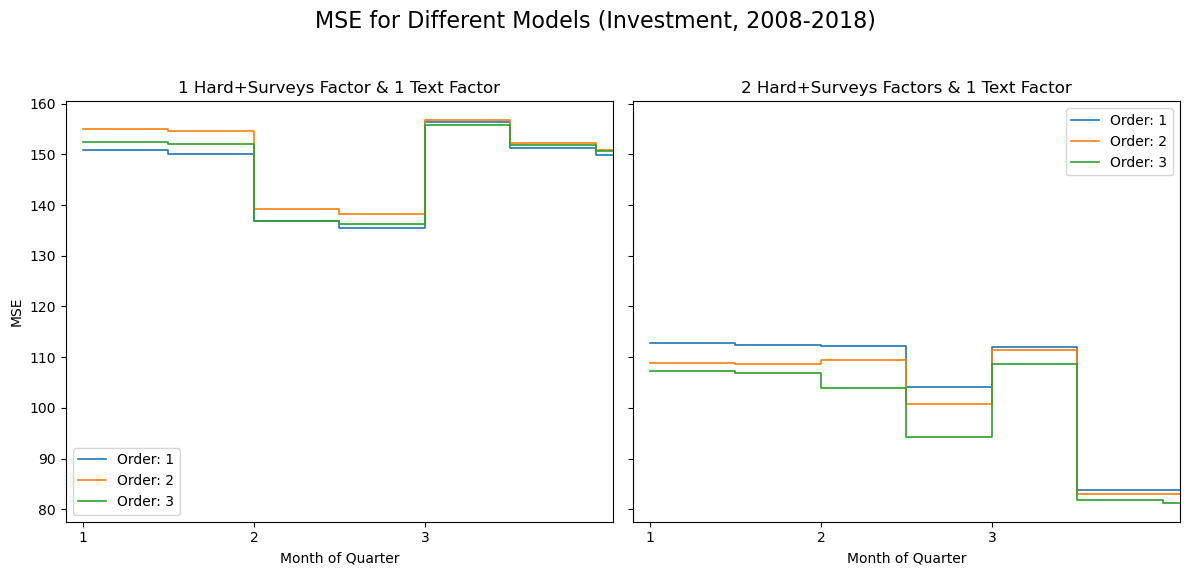

In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd

vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]
q_var = 'Investment'
text_type = "topics_BCC"
estimation_period = "2009"
num_topics = "200"
source = "all"
selected = ""

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Define the directory containing MSE files
mse_dir = f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_{q_var}_update"

# Create a figure with 1 row and 2 columns of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Loop over the number of HardSurveys factors (1 or 2)
for i, num_factors in enumerate(range(1, 3)):
    ax = axs[i]
    # Within each subplot, loop over factor orders 1 to 3
    for order in range(1, 4):
        # Construct file name based on the model's parameters
        factors_str = f"HS_{num_factors}_{order}"
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_file_path = os.path.join(mse_dir, mse_file_name)
        
        # Load the MSE values from file
        mse_df = pd.read_csv(mse_file_path)
        # Construct y values based on the vintages
        y_values = [mse_df[col].iloc[0] for col in vintage_col_names]
        
        # Extend the y-values so the step function holds the last value
        y_extended = y_values.copy()
        y_extended.append(y_values[-1]) # Repeat the last value
        
        # Plot the step function for the current model
        ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                 label=f"Order: {order}")
        
    # Customize the subplot
    ax.set_xlabel("Month of Quarter")
    # Set ticks only at 1, 2, and 3 to mark the beginning of each month
    ax.set_xticks([1, 2, 3])
    ax.set_xlim(0.9, 4.1)
    ax.set_title(f"{num_factors} Hard+Surveys Factor{'s' if num_factors > 1 else ''} & 1 Text Factor")
    if i == 0:  # Only the leftmost subplot gets the y-axis label
        ax.set_ylabel("MSE")
    ax.legend()

plt.suptitle(f"MSE for Different Models ({q_var}, 2008-2018)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_{q_var}_update", exist_ok=True)
base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_{q_var}_update", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_2008-2018_{q_var}")
plt.savefig(f"{base_filename}.png", format="png")
plt.savefig(f"{base_filename}.eps", format="eps")

plt.show()

Plot MSE values for all models evaluated over the 2008–2010 and 2011-2018 periods.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


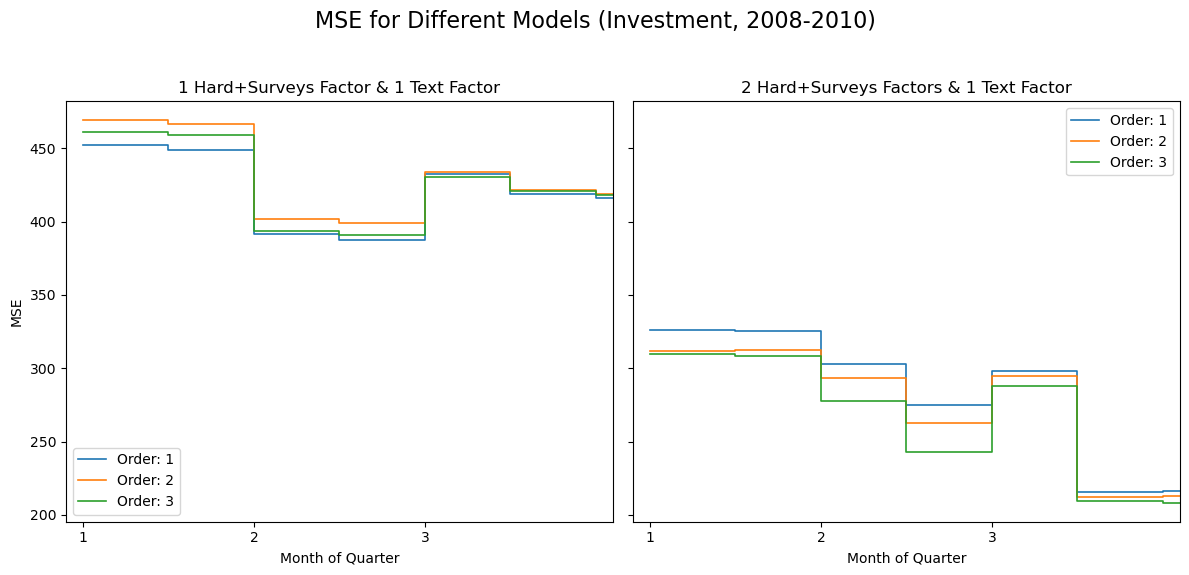

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


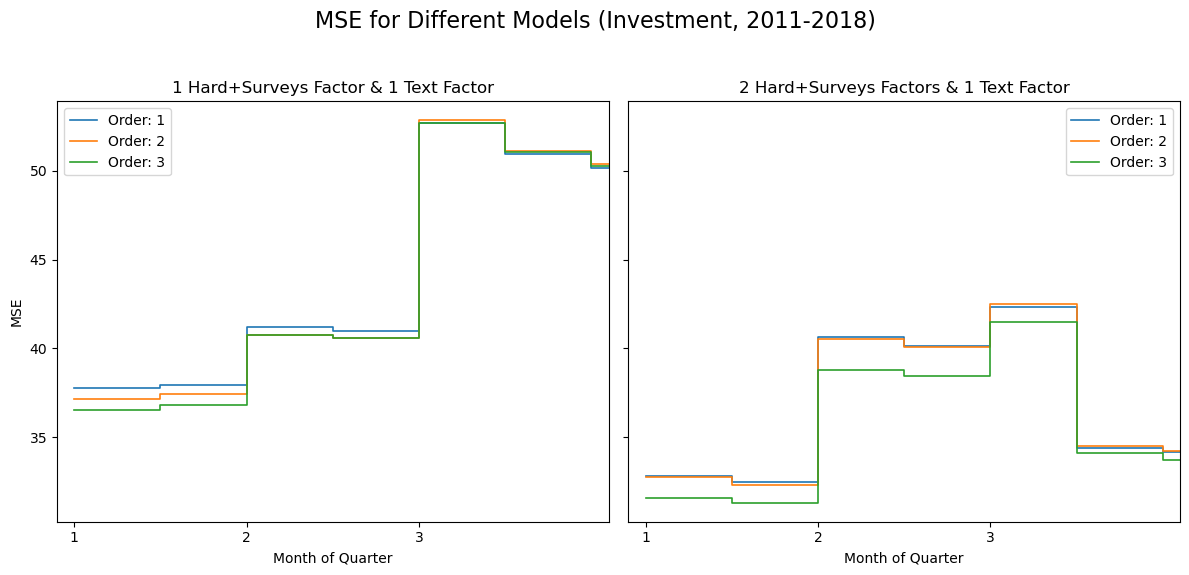

In [3]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'Investment'
text_type = "topics_BCC"
estimation_period = "2009"
num_topics = "200"
source = "all"
selected = ""
forecasts_dir = f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_{q_var}_update"
actual_growth_file = f"../{q_var}_growth_actual_update.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Define two periods
periods = {
    "2008-2010": lambda df: df["date_float"] < 2011,
    "2011-2018": lambda df: df["date_float"] >= 2011
}

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Loop over each period and create a separate figure
for period_label, period_filter in periods.items():
    
    # Create a figure with 1 row and 2 columns of subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
    
    # Loop over the number of HardSurveys factors (1 or 2)
    for i, num_factors in enumerate(range(1, 3)):
        ax = axs[i]
        # Within each subplot, loop over factor orders 1 to 3
        for order in range(1, 4):
            # Construct forecast file name, e.g., "forecasts_Investment_HS_1_1.csv"
            factors_str = f"HS_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)
    
            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)
            
            # Merge forecasts with actual growth 
            merged = pd.merge(forecasts, actual_growth, on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)
            
            # Filter merged data for the current period
            merged_period = merged[ period_filter(merged) ]
            
            # Calculate MSE for each vintage column over the filtered period
            mse_dict = {}
            for col in vintage_col_names:
                mse = ((merged_period[col] - merged_period["growth"]) ** 2).mean()
                mse_dict[col] = mse
                
            # Construct y values based on the vintages
            y_values = [mse_dict[col] for col in vintage_col_names]
            
            # Extend the y-values so the step function holds the last value
            y_extended = y_values.copy()
            y_extended.append(y_values[-1]) # Repeat the last value
            
            # Plot the step function for the current model (order)
            ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                    label=f"Order: {order}")
            
        # Customize the subplot
        ax.set_xlabel("Month of Quarter")
        # Set ticks only at 1, 2, and 3 to mark the beginning of each month
        ax.set_xticks([1, 2, 3])
        ax.set_xlim(0.9, 4.1)
        ax.set_title(f"{num_factors} Hard+Surveys Factor{'s' if num_factors > 1 else ''} & 1 Text Factor")
        if i == 0:  # Only the leftmost subplot gets the y-axis label
            ax.set_ylabel("MSE")
        ax.legend()
   
    plt.suptitle(f"MSE for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_{q_var}_update", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_{q_var}_update", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()

Plot forecasts vs actual growth values for all models and different time periods (2008-2010, 2008-2018, and 2011-2018).

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


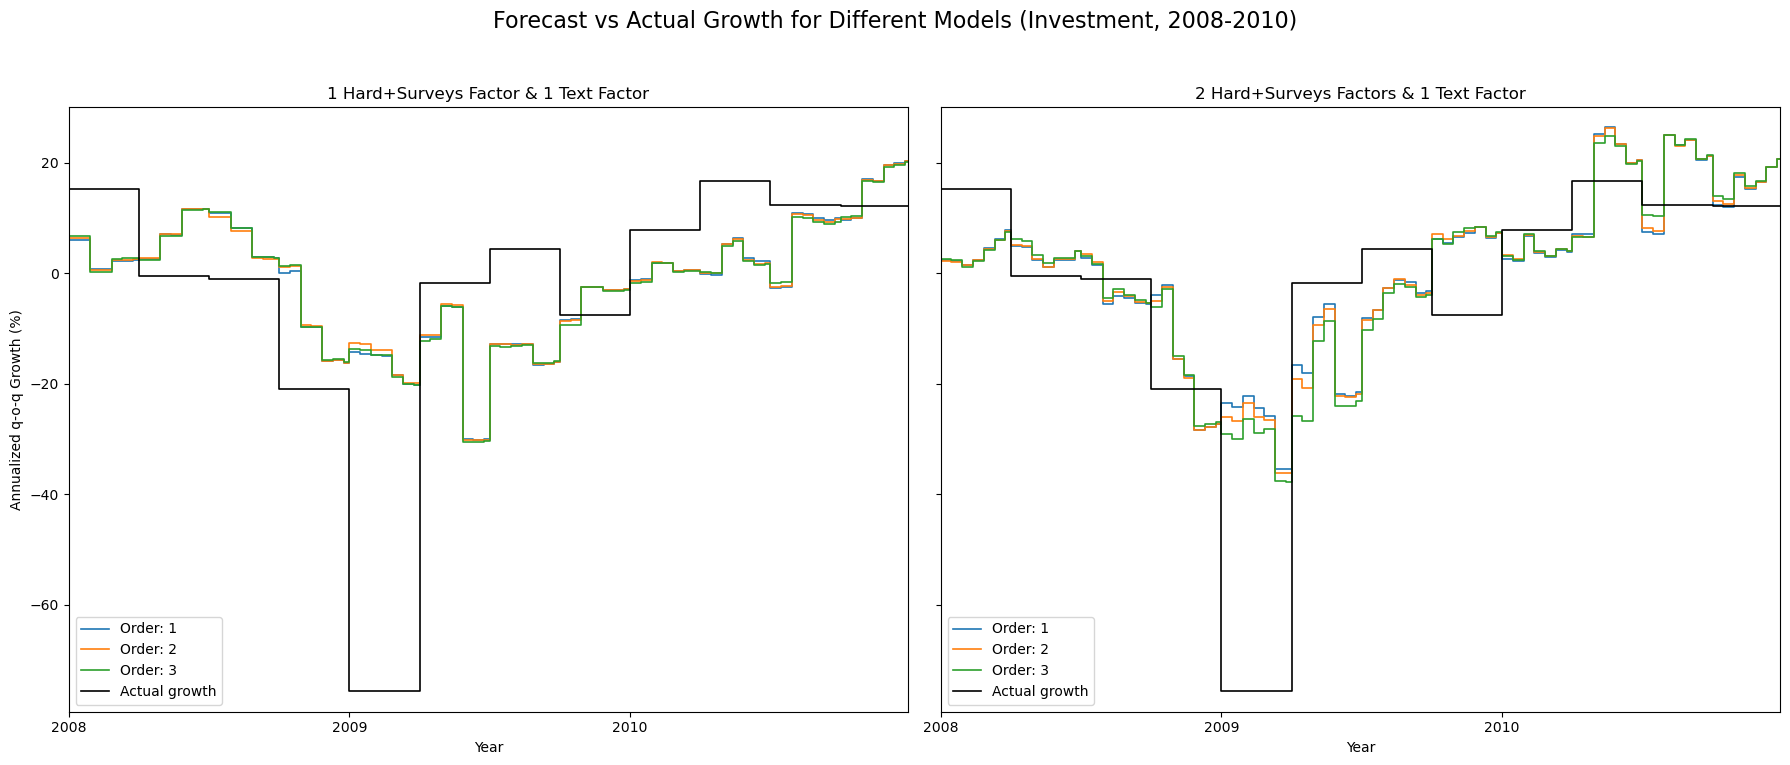

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


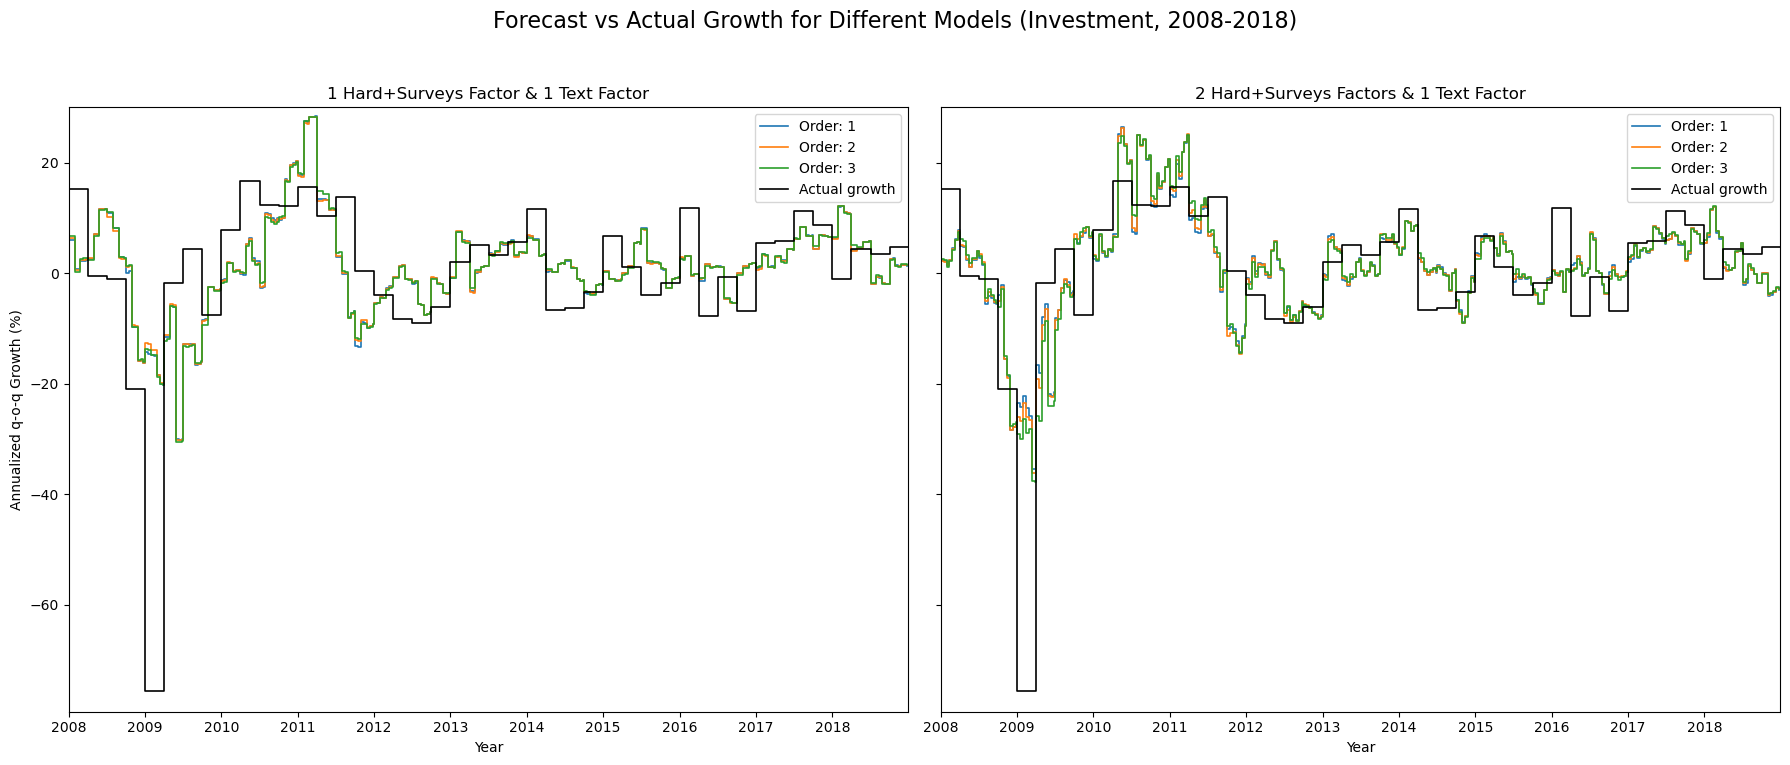

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


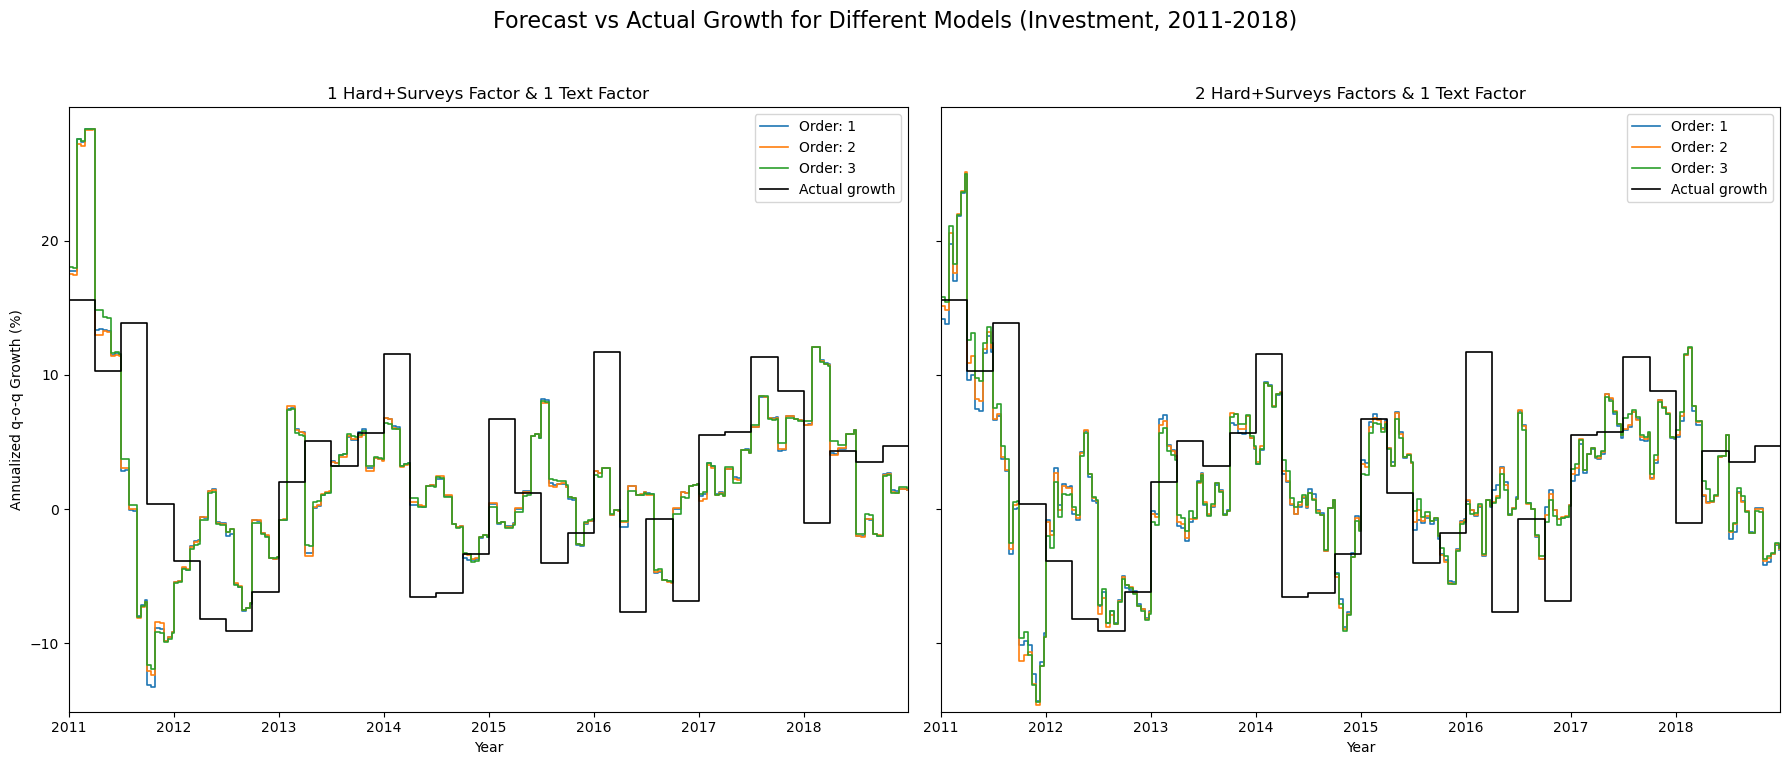

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Convert quarter strings like "2008-03" into a float (e.g. 2008.00 for Q1, 2008.25 for Q2, etc.)
def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'Investment'
text_type = "topics_BCC"
estimation_period = "2009"
num_topics = "200"
source = "all"
selected = ""
forecasts_dir = f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_{q_var}_update"
actual_growth_file = f"../{q_var}_growth_actual_update.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Assign 7 small offsets within each quarter, so each quarter has 7 forecast points
offsets = np.linspace(0, 0.23, 7)

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Build x,y arrays for the actual growth
x_act = actual_growth["date_float"].tolist()
y_act = actual_growth["growth"].tolist()

# Define period configurations: x-axis limits and tick positions for each period
period_configs = {
    "2008-2010": {"xlim": (2008, 2010.99), "xticks": list(range(2008, 2011))},
    "2008-2018": {"xlim": (2008, 2018.99), "xticks": list(range(2008, 2019))},
    "2011-2018": {"xlim": (2011, 2018.99), "xticks": list(range(2011, 2019))}
}

# Loop over each period configuration to create and save separate plots
for period_label, config in period_configs.items():
    
    # Extend the actual growth arrays so that the step function continues until the end of the x-axis
    if period_label in ["2008-2018", "2011-2018"]:
        x_act_extended = x_act.copy()
        x_act_extended.append(config["xlim"][1])
        y_act_extended = y_act.copy()
        y_act_extended.append(y_act[-1])
    else:
        x_act_extended = x_act
        y_act_extended = y_act

    # Create a figure with 1 row and 2 columns for the two Hard+Surveys factor counts
    fig, axs = plt.subplots(1, 2, figsize=(18, 8), sharey=True)

    # Loop over the number of HardSurveys factors (1 or 2)
    for i, num_factors in enumerate([1, 2]):
        ax = axs[i]

        # For each HardSurveys factor count, plot forecasts for orders 1, 2, and 3
        for order in range(1, 4):

            # Construct forecast file name, e.g., "forecasts_Investment_HS_1_1.csv"
            factors_str = f"HS_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)

            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)

            # Merge forecasts with actual growth dates
            merged = pd.merge(forecasts, actual_growth[['date']], on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)

            # Build forecast x and y arrays 
            x_fore = []
            y_fore = []
            for idx, row in merged.iterrows():
                base_x = row["date_float"]
                # For each of the 7 vintage columns, define an x-position and take that forecast value
                for j, col in enumerate(vintage_col_names):
                    x_fore.append(base_x + offsets[j])
                    y_fore.append(row[col])

            # Plot the forecast step curve for the current order
            ax.step(x_fore, y_fore, where='post', linewidth=1.2, label=f"Order: {order}")

        # Plot actual growth as a step plot in each subplot
        ax.step(x_act_extended, y_act_extended, where='post', color='black', linewidth=1.2, label="Actual growth")

        # Customize the subplot
        ax.set_xlabel("Year")
        ax.set_xlim(config["xlim"][0], config["xlim"][1])
        ax.set_xticks(config["xticks"])
        
        # Set y-axis limits based on the data within the period range
        x_min, x_max = config["xlim"]
        def filter_points(x_arr, y_arr, x_min, x_max):
            return [y for x, y in zip(x_arr, y_arr) if x_min <= x <= x_max]

        # Filter y-values
        y_filtered = filter_points(x_fore, y_fore, x_min, x_max)
        y_act_filtered = filter_points(x_act_extended, y_act_extended, x_min, x_max)
        
        # Combine all filtered y-values
        combined_y = y_filtered + y_act_filtered
        ax.set_ylim(1.05 * min(combined_y), 1.2 * max(combined_y))
        
        ax.set_title(f"{num_factors} Hard+Surveys Factor{'s' if num_factors > 1 else ''} & 1 Text Factor")
        if i == 0:
            ax.set_ylabel("Annualized q-o-q Growth (%)")
        ax.legend()
        
    plt.suptitle(f"Forecast vs Actual Growth for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_{q_var}_update", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_{q_var}_update", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_forecast_vs_actual_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()